# Land cover supervised classification using Sentinel-2
---

The file contains methods for:
 1. loading and displaying Sentinel-2 image
 2. loading and displaying localisations of training points
 3. data transformation for supervised classification
 4. training classifiers: 
     - Decision Tree
     - Random Forest
     - Support Vector Machine
 5. classification of the whole image using the trained classifiers
 6. loading and displaying localisations of validation points
 7. assesing classification performance using validation points
 
 ---
 
 <i>The file written and tested using Jupyter Notebook ver. 6.1.4 (core ver. 4.6.3) on Anaconda ver. 4.9.2 in Windows OS </i>
 
 <i>Author: Artur Nowakowski, Warsaw University of Technology, contact: artur.nowakowski@wfp.org </i>

## Configuration

In [26]:
# folder containing S-2 data
imFolder = r'C:\Artur\imperativespace\S2_data'

# training data files
dWater = r'C:\Artur\imperativespace\training_data\water.txt'
dArtificial = r'C:\Artur\imperativespace\training_data\artificial_surfaces.txt'
dLowVeg = r'C:\Artur\imperativespace\training_data\low_vegetation.txt'
dTrees = r'C:\Artur\imperativespace\training_data\tree_cover.txt'

# folder for storing results
resFolder = r'C:\Artur\imperativespace\visualisations'

# validation data file
valPoints = r'C:\Artur\imperativespace\validation_data\validation_points.txt'


## 1. Loading and displaying Sentinel-2 image

In [2]:
# loading Sentinel-2 (S2) image
#
# we assume that each band is saved in a separated tif file, all bands are resampled to 10x10 m resolution

from skimage import io

# loading S2 bands from a folder
coll = io.ImageCollection(imFolder + '\*.tif')

# a list of loaded files
print(coll.files)

band_names=['B1','B2','B3','B4','B5','B6','B7','B8','B8A','B9','B10','B11','B12']


['C:\\Artur\\imperativespace\\S2_data\\B1.tif', 'C:\\Artur\\imperativespace\\S2_data\\B2.tif', 'C:\\Artur\\imperativespace\\S2_data\\B3.tif', 'C:\\Artur\\imperativespace\\S2_data\\B4.tif', 'C:\\Artur\\imperativespace\\S2_data\\B5.tif', 'C:\\Artur\\imperativespace\\S2_data\\B6.tif', 'C:\\Artur\\imperativespace\\S2_data\\B7.tif', 'C:\\Artur\\imperativespace\\S2_data\\B8.tif', 'C:\\Artur\\imperativespace\\S2_data\\B8a.tif', 'C:\\Artur\\imperativespace\\S2_data\\B9.tif', 'C:\\Artur\\imperativespace\\S2_data\\B10.tif', 'C:\\Artur\\imperativespace\\S2_data\\B11.tif', 'C:\\Artur\\imperativespace\\S2_data\\B12.tif']


In [3]:
# displaying image
import numpy as np
from skimage import exposure

# function for creating a color composition including histogram stretching
def composition(band1,band2,band3):
    im_comp=np.dstack([band1/band1.max(), band2/band2.max(), band3/band3.max()])
    for i in range(3):
        v_min, v_max = np.percentile(im_comp[:,:,i],(1,98))
        im_comp[:,:,i] = exposure.rescale_intensity(im_comp[:,:,i],in_range=(v_min,v_max))
    return im_comp

Bands in Sentinel-2

| No. | Name |
| :--- | :--- |
| 1 |  Coastal aerosol |
| 2 |  Blue |
| 3 |  Green |
| 4 |  Red |
| 5 |  Red Edge 1 |
| 6 |  Red Edge 2 |
| 7 |  Red Edge 3 |
| 8 |  NIR |
| 8A |  NIR narrow |
| 9 |  Water vapor |
| 10 |  SWIR - cirrus |
| 11 |  SWIR 1 |
| 12 |  SWIR 2 |

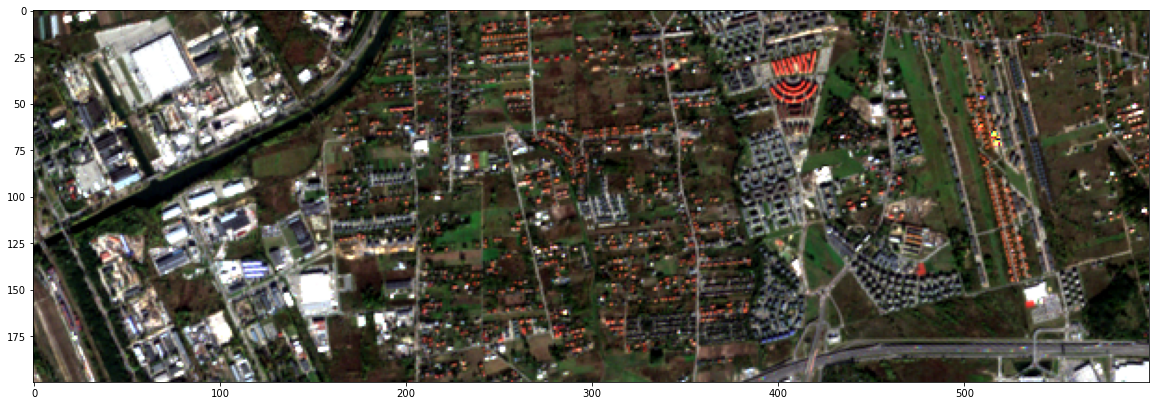

In [4]:
# calling 'composition' function for red, green and blue bands (bands no. 4, 3, and 2 in Sentinel-2)
import matplotlib.pyplot as plt

im_comp = composition(coll[3],coll[2],coll[1])
plt.figure(figsize=(20,10))
plt.imshow(im_comp)

## 2. Loading and displaying localisations of training points

Four classes are considered:
 - water
 - artificial surfaces
 - low vegetation
 - tree cover

In [5]:
# loading localisation of training points
#
# for each class localisations of training points are stored in a separated text file, 
# which contains lines consisting of pairs of integer numbers Y and X separated by line space:
# Y is a horizontal (row) pixel coordinate of a training point
# X is a vertical (column) pixel coordinate of the point

import numpy as np

p_water = np.loadtxt(dWater,dtype='int')
p_artificial = np.loadtxt(dArtificial,dtype='int')
p_low_veg = np.loadtxt(dLowVeg,dtype='int')
p_trees = np.loadtxt(dTrees,dtype='int')

LC_class_names = ['water', 'artificial', 'low vegetation', 'tree cover'];


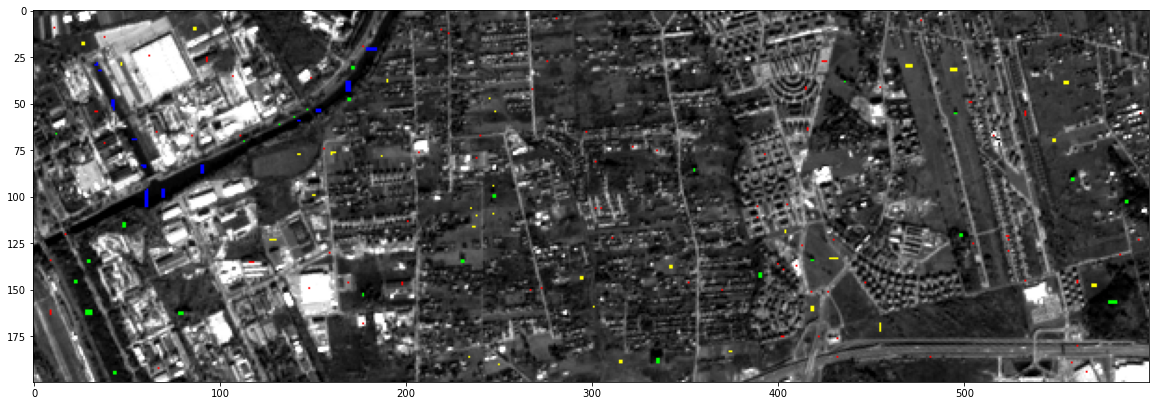

In [7]:
# displaying localisation of training points on the S2 image
from skimage.color import rgb2gray

# converting the S2 composition to gray scale
im_comp_p=np.zeros(im_comp.shape)
im_comp_p[:,:,0]=rgb2gray(im_comp)
im_comp_p[:,:,1]=rgb2gray(im_comp)
im_comp_p[:,:,2]=rgb2gray(im_comp)

# marking in blue the training points for 'water' class
im_comp_p[p_water[:,0],p_water[:,1],0] =0
im_comp_p[p_water[:,0],p_water[:,1],1] =0
im_comp_p[p_water[:,0],p_water[:,1],2] =1

# marking in red the training points for 'artificial surfaces' class
im_comp_p[p_artificial[:,0],p_artificial[:,1],0] =1
im_comp_p[p_artificial[:,0],p_artificial[:,1],1] =0
im_comp_p[p_artificial[:,0],p_artificial[:,1],2] =0

# marking in yellow the training points for 'low vegetation' class
im_comp_p[p_low_veg[:,0],p_low_veg[:,1],0] =1
im_comp_p[p_low_veg[:,0],p_low_veg[:,1],1] =1
im_comp_p[p_low_veg[:,0],p_low_veg[:,1],2] =0

# marking in green the training points for 'tree cover' class
im_comp_p[p_trees[:,0],p_trees[:,1],0] =0
im_comp_p[p_trees[:,0],p_trees[:,1],1] =1
im_comp_p[p_trees[:,0],p_trees[:,1],2] =0

plt.figure(figsize=(20,10))
plt.imshow(im_comp_p)

## 3. Data transformation for supervised classification

Data transformation aims at preparing a data table required as an input by the classification algorithms in Python. For each training point its values in bands are read from the S2 image and stored in a separated row of the table.
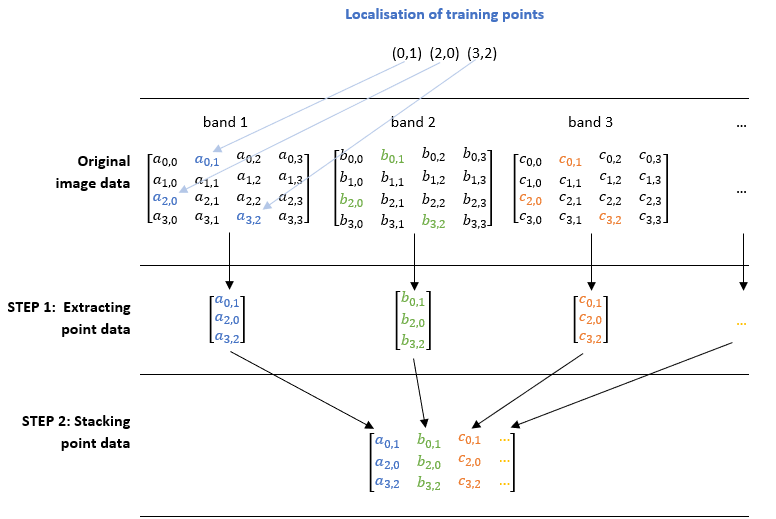


In [8]:
# 'water' class

# step 1 - reading band values for training pixels
bands=[]
for i in range(len(coll)):
    band = np.asarray(coll[i].data)[p_water[:,0],p_water[:,1]]
    bands.append(band)
    
# step 2 - stacking band vectors into a table    
X_water=np.stack(bands).T


# 'artificial surfaces' class

# step 1 - reading band values for training pixels
bands=[]
for i in range(len(coll)):
    band = np.asarray(coll[i].data)[p_artificial[:,0],p_artificial[:,1]]
    bands.append(band)
    
# step 2 - stacking band vectors into a table    
X_artificial=np.stack(bands).T


# 'low vegetation' class

# step 1 - reading band values for training pixels
bands=[]
for i in range(len(coll)):
    band = np.asarray(coll[i].data)[p_low_veg[:,0],p_low_veg[:,1]]
    bands.append(band)
    
# step 2 - stacking band vectors into a table    
X_low_veg=np.stack(bands).T


# 'tree cover' class

# step 1 - reading band values for training pixels
bands=[]
for i in range(len(coll)):
    band = np.asarray(coll[i].data)[p_trees[:,0],p_trees[:,1]]
    bands.append(band)
    
# step 2 - stacking band vectors into a table    
X_trees=np.stack(bands).T


# stacking data for all classes in one table
X=np.vstack((X_water,X_artificial,X_low_veg,X_trees))


# creating a vector containing class numbers
Y=np.vstack((np.ones((X_water.shape[0], 1)),2*np.ones((X_artificial.shape[0], 1)), \
             3*np.ones((X_low_veg.shape[0], 1)),4*np.ones((X_trees.shape[0], 1))))


## 4. Training classifiers


### 4.1. Training Decision Tree classifier
Decision tree is an example of single classifier wich determines class decision based on a set of rules established in during the training process 

In [11]:
# training a classifier
#
# used parameters:
# max_depth - the maximum depht of a tree

from sklearn.tree import DecisionTreeClassifier

dt_clf = DecisionTreeClassifier(max_depth = 10) 

dt_clf.fit(X, np.ravel(Y))

DecisionTreeClassifier(max_depth=10)

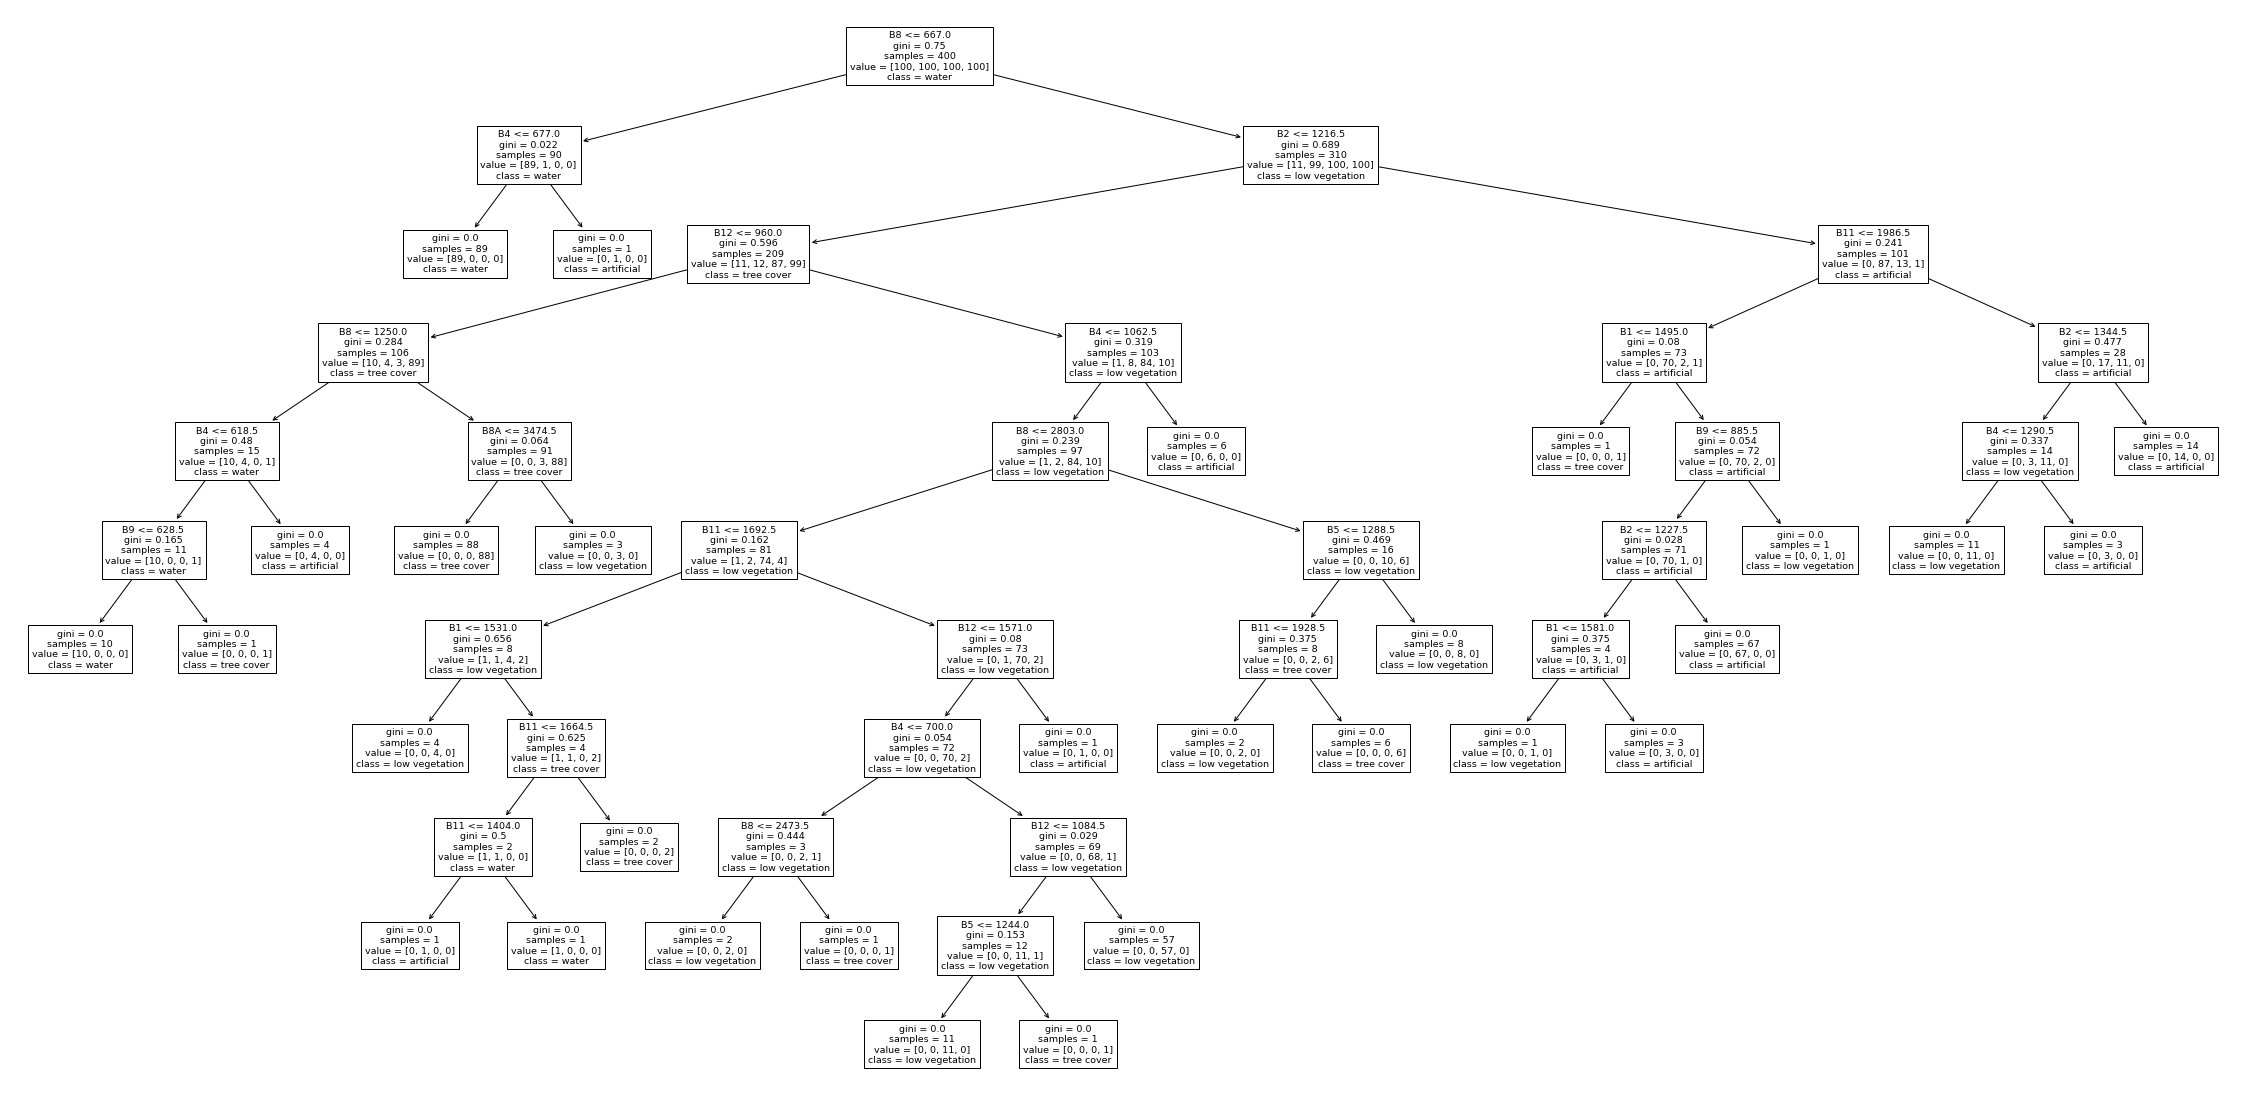

In [13]:
# visualisation of the trained decision tree

from sklearn.tree import plot_tree

fig = plt.figure(figsize=(40,20))
plot_tree(dt_clf, feature_names = band_names, class_names = LC_class_names ) 
plt.show()

# please double click on the plot to see details

### 4.2 Training Random Forest classifier
Random Forest is an example of ensemble classifier consisting of many decision trees which are obtained by training on permuted version of training dataset  

In [14]:
# training a classifier

# Random Forest
#
# used parameters:
# n_estimators - number of trees in a forest
# max_depth - the maximum depht of a tree
# random_state - controls both the randomness of the bootstrapping of the samples used when building trees

from sklearn.ensemble import RandomForestClassifier
rf_clf = RandomForestClassifier(n_estimators=10, \
                             max_depth=5, \
                             random_state=0)    

rf_clf.fit(X, np.ravel(Y))

RandomForestClassifier(max_depth=5, n_estimators=10, random_state=0)

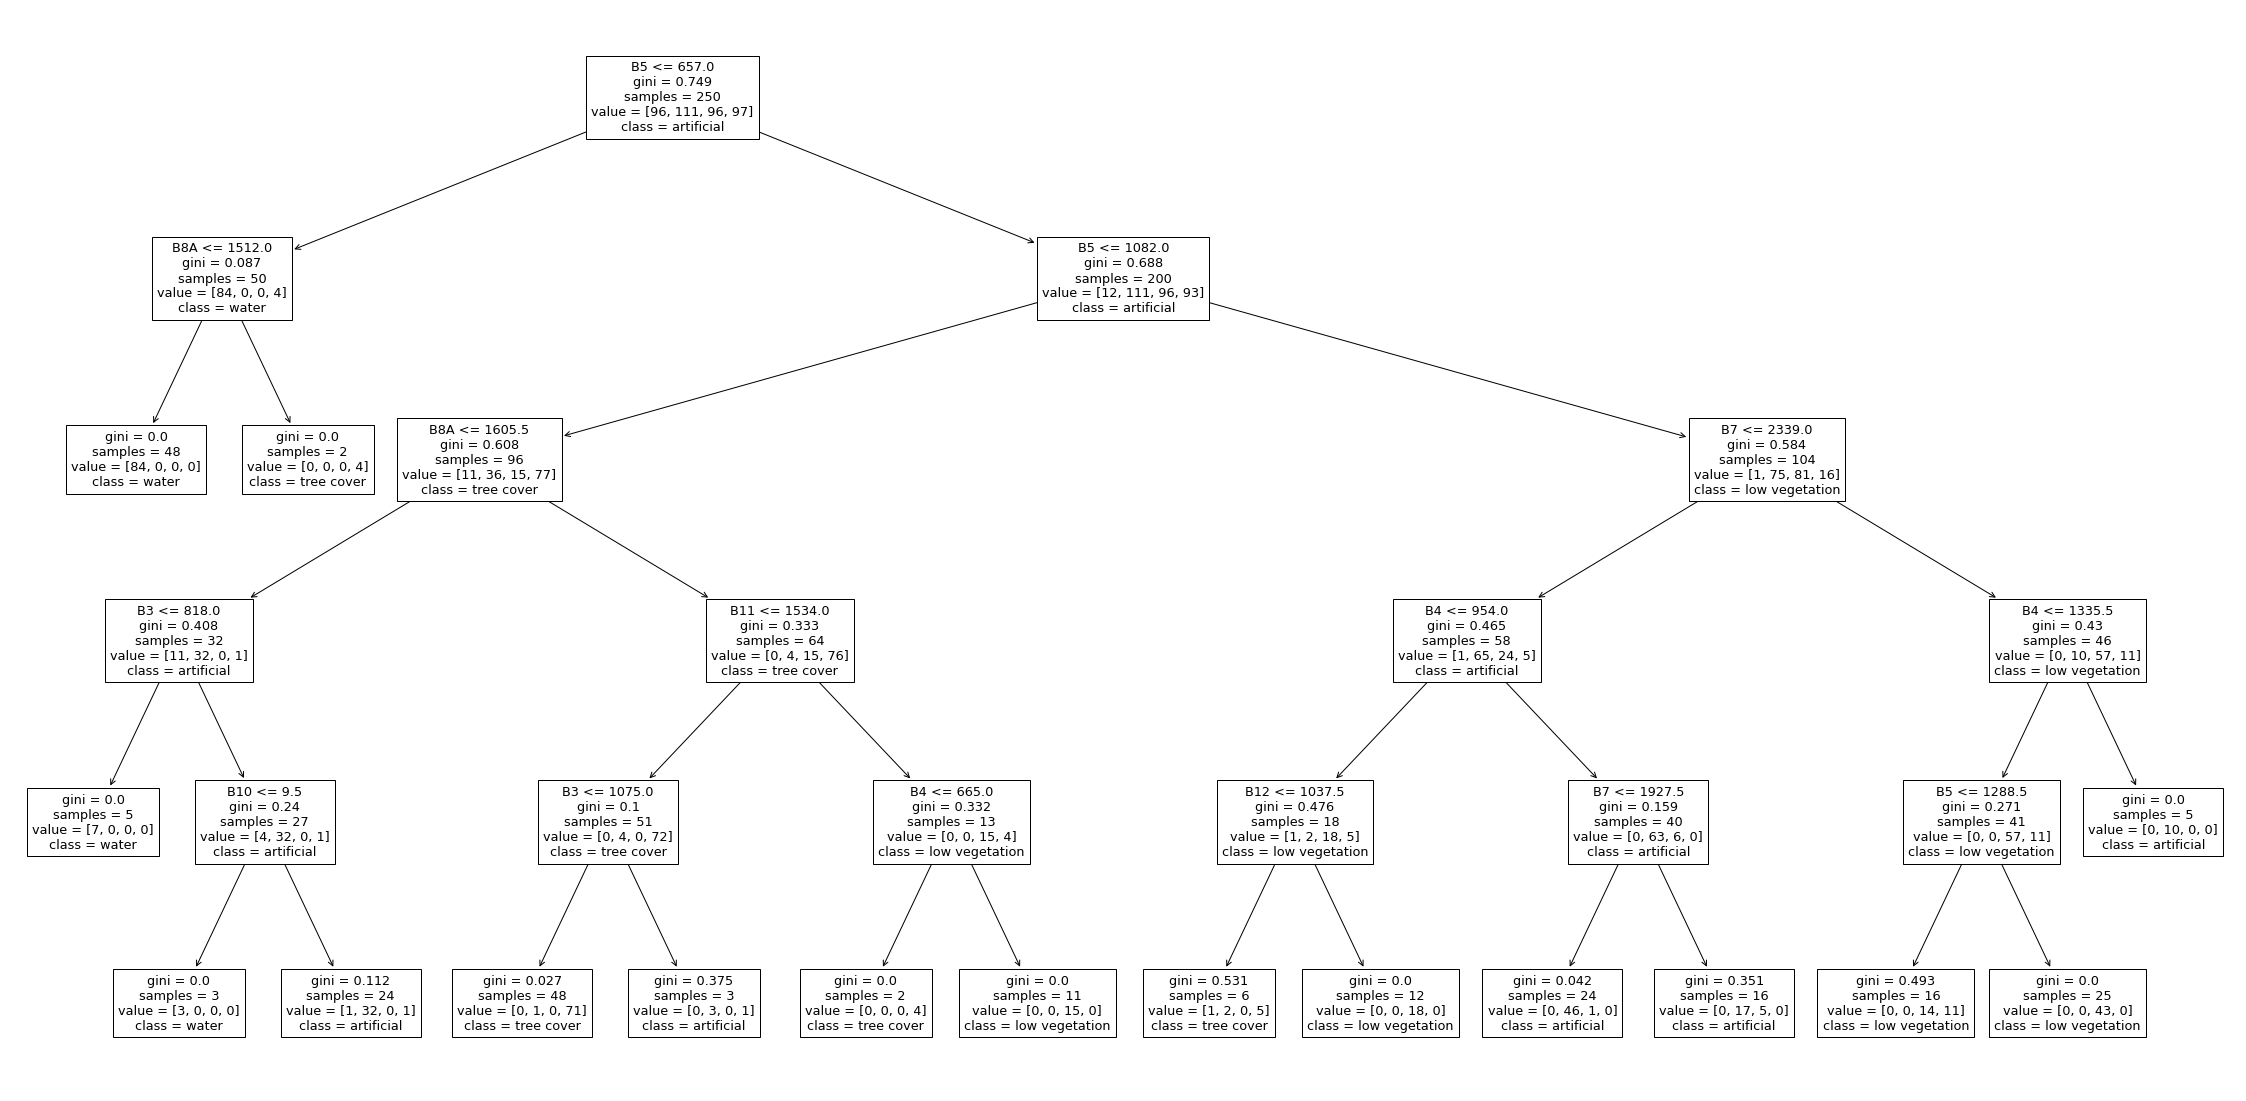

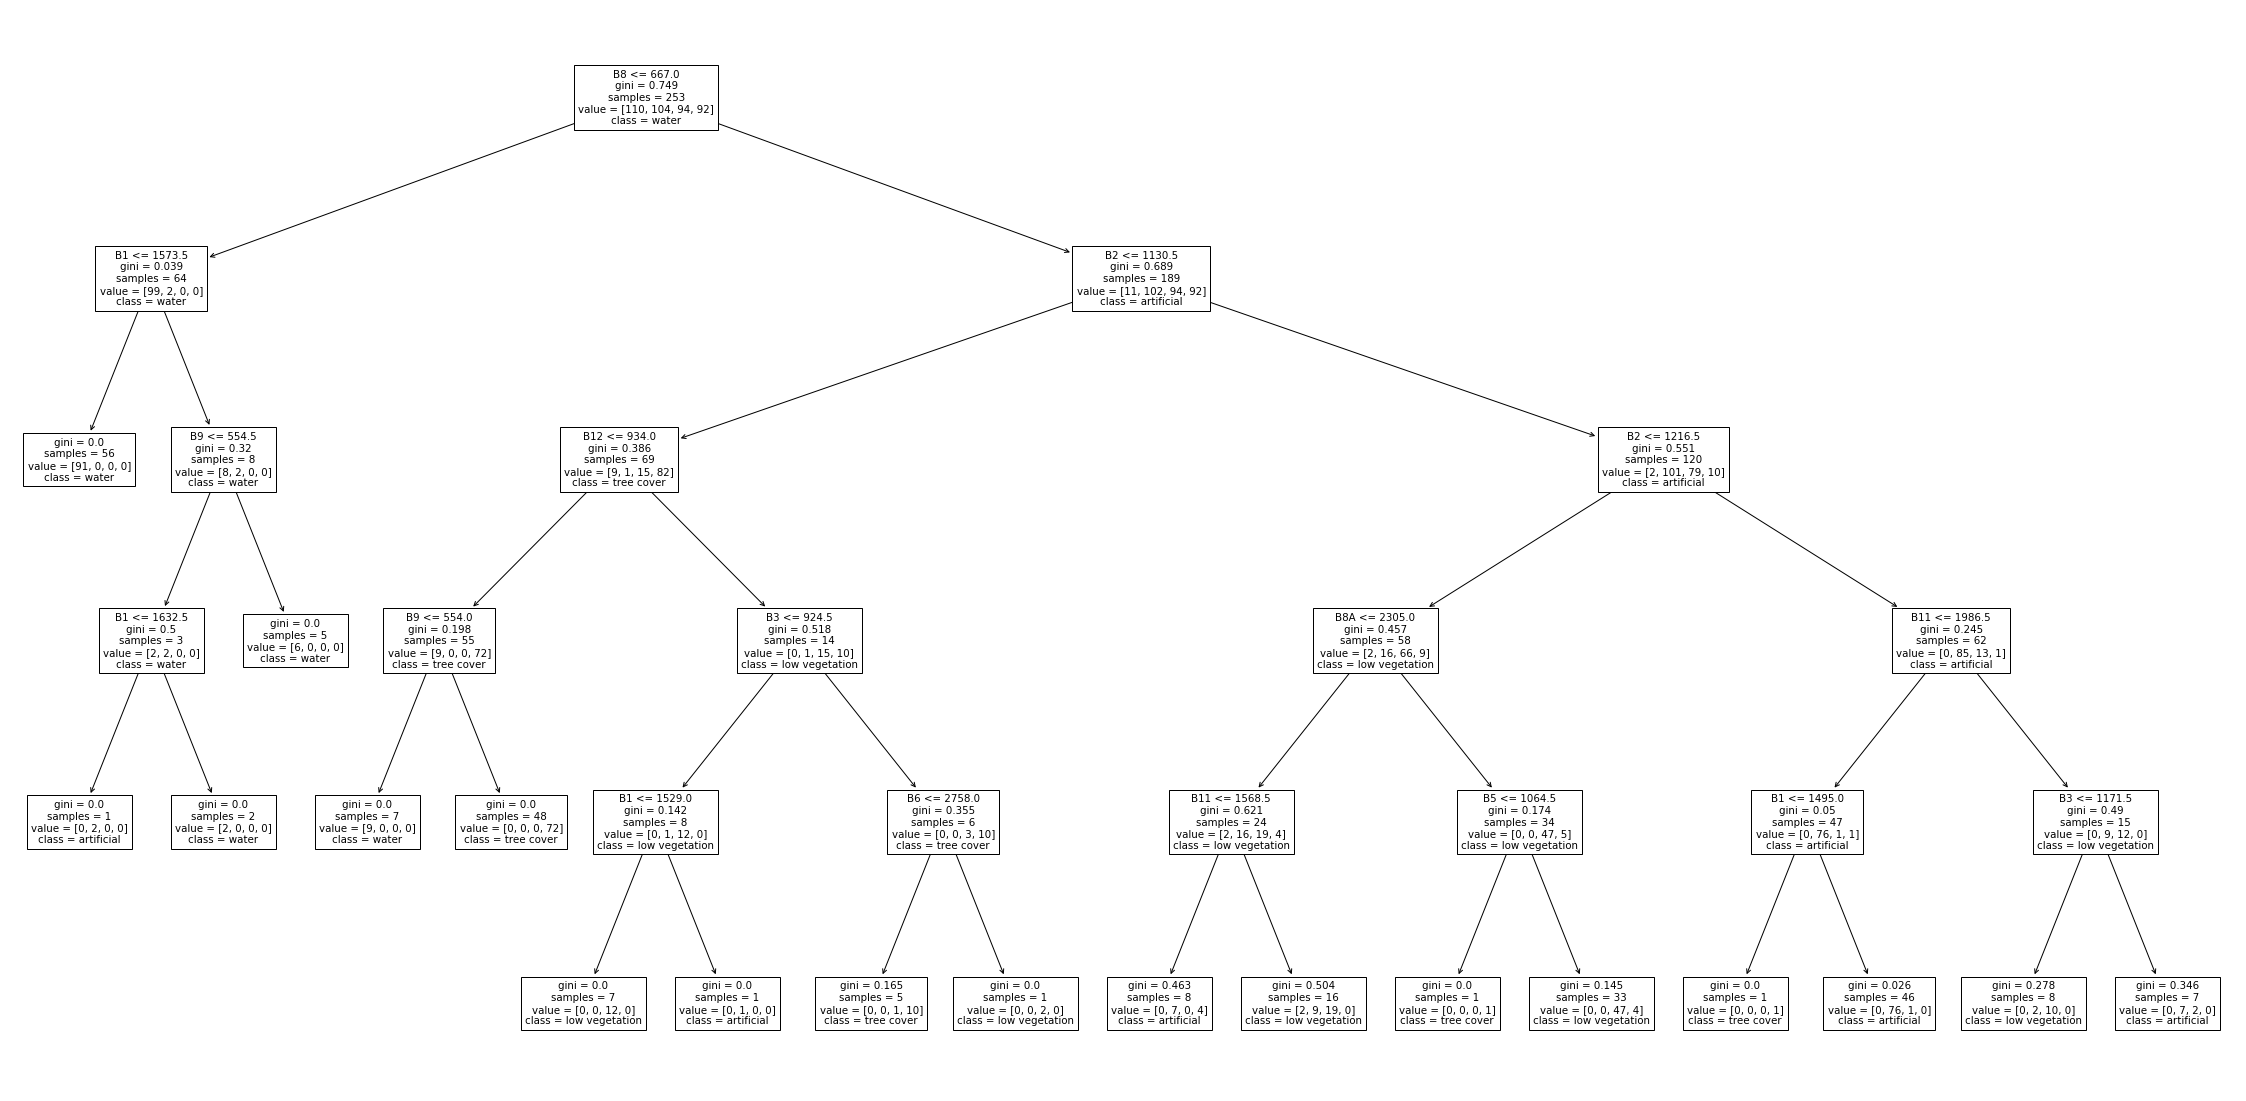

In [144]:
# visualisation of the first N trees from Random Forest

N=2

for i in range(N):
    fig = plt.figure(figsize=(40,20))
    tree.plot_tree(rf_clf.estimators_[i],feature_names = band_names, class_names = LC_class_names ) 
    plt.show()
    
# please double click on the plot to see details

### 4.3 Support Vector Machine classifier
SVM is an example of a classifier which builds hyperplanesin feature space to separate classes  

In [35]:
# training a classifier

# Support Vector Machine

from sklearn import svm

svm_clf = svm.SVC()
svm_clf.fit(X, np.ravel(Y))   


SVC()

## 5. Classification of the whole image using the trained classifiers

### Data transformation - all pixels in image

In [15]:
# transforming data to the format required by the classification function - as mentioned 
# in sec. "Data transformation for supervised classification"
bands=[]
for i in range(len(coll)):
    band = np.asarray(coll[i].data).flatten()
    bands.append(band)

X_all=np.stack(bands).T


### Prediction using trained Decision Tree

In [16]:
# prediction
Y_pred_dt = dt_clf.predict(X_all)

Text(340, 6, 'Tree cover')

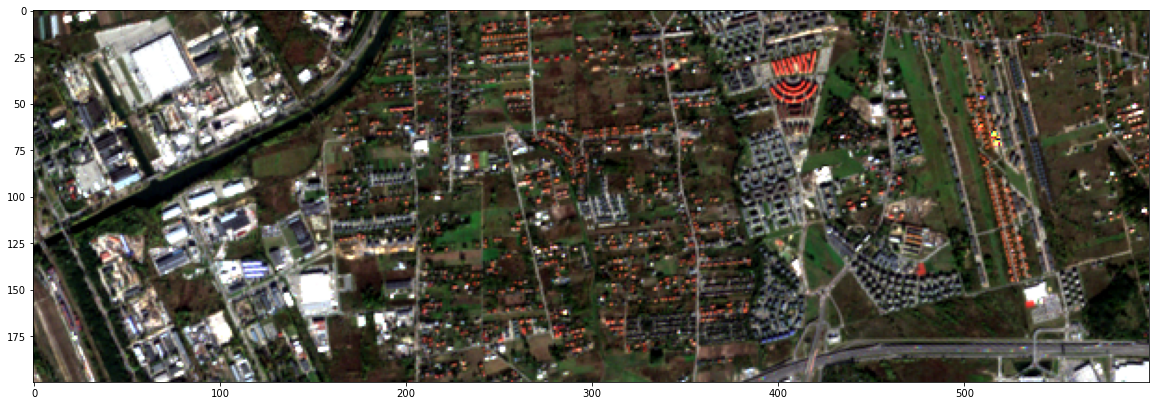

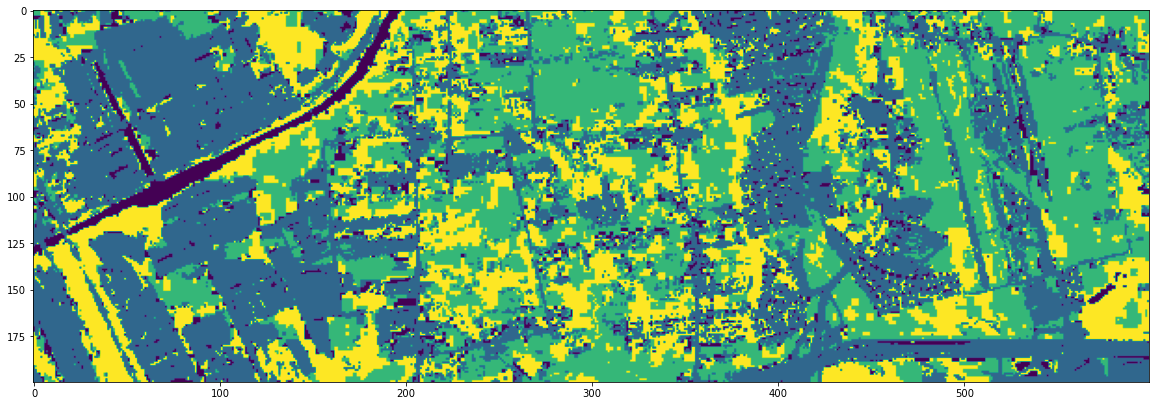

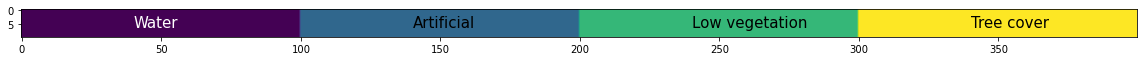

In [17]:
# visualisation of results

# original image
plt.figure(figsize=(20,10))
plt.imshow(im_comp)

# classified image
Y_im_dt = Y_pred_dt.reshape(coll[1].shape)
plt.figure(figsize=(20,10))
plt.imshow(Y_im_dt)

# legend
fig = plt.figure(figsize=(20,1))
ax = fig.add_subplot(111)
plt.imshow(np.hstack((np.zeros((10,100)), np.ones((10,100)),2*np.ones((10,100)),3*np.ones((10,100)))))
ax.text(40, 6, 'Water', fontsize=15,  color='white')
ax.text(140, 6, 'Artificial', fontsize=15,  color='black')
ax.text(240, 6, 'Low vegetation', fontsize=15,  color='black')
ax.text(340, 6, 'Tree cover', fontsize=15,  color='black')

In [40]:
# saving classification results
io.imsave(resFolder+'\classification_dt.tif',Y_im_dt)

### Prediction using trained Random Forest

In [19]:
# prediction
Y_pred_rf = rf_clf.predict(X_all)

Text(340, 6, 'Tree cover')

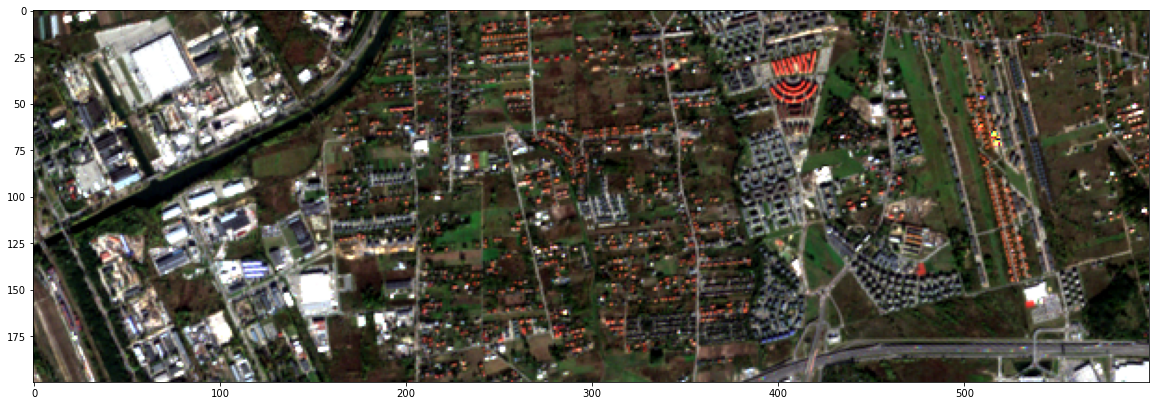

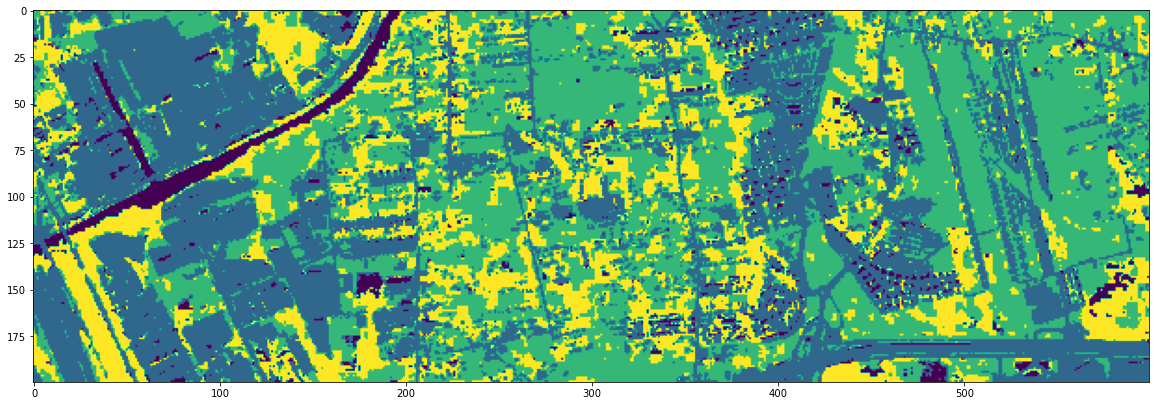

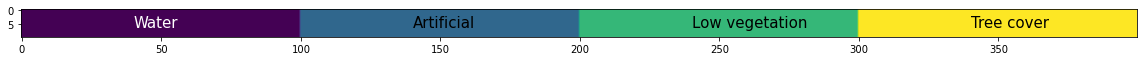

In [20]:
# original image
plt.figure(figsize=(20,10))
plt.imshow(im_comp)

# visualisation of results
Y_im_rf = Y_pred_rf.reshape(coll[1].shape)
plt.figure(figsize=(20,10))
plt.imshow(Y_im_rf)

# legend
fig = plt.figure(figsize=(20,1))
ax = fig.add_subplot(111)
plt.imshow(np.hstack((np.zeros((10,100)), np.ones((10,100)),2*np.ones((10,100)),3*np.ones((10,100)))))
ax.text(40, 6, 'Water', fontsize=15,  color='white')
ax.text(140, 6, 'Artificial', fontsize=15,  color='black')
ax.text(240, 6, 'Low vegetation', fontsize=15,  color='black')
ax.text(340, 6, 'Tree cover', fontsize=15,  color='black')

In [41]:
# saving classification results
io.imsave(resFolder+'\classification_rf.tif',Y_im_rf)

### Prediction using trained Support Vector Machine

In [36]:
# prediction
Y_pred_svm = svm_clf.predict(X_all)

Text(340, 6, 'Tree cover')

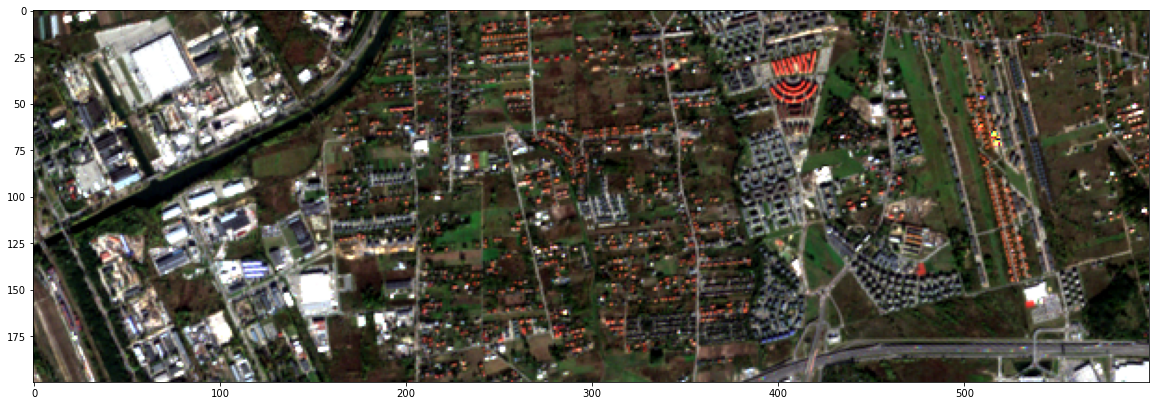

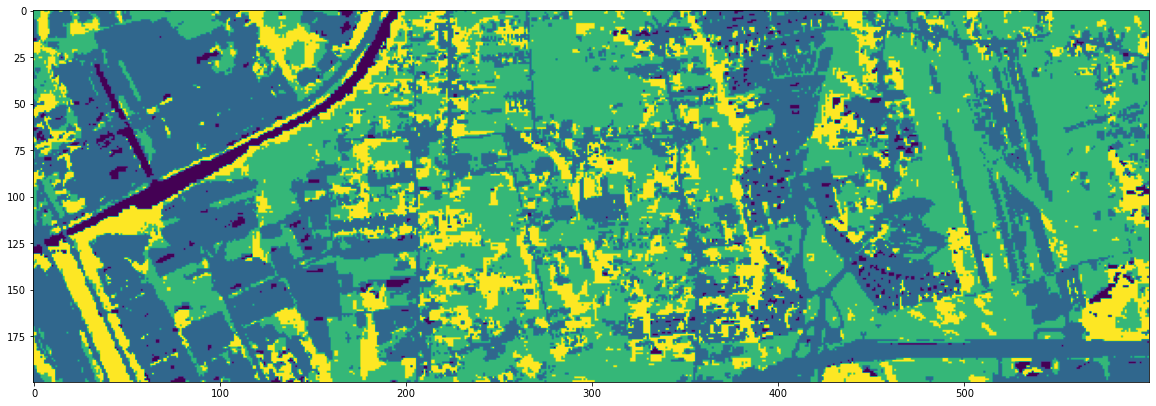

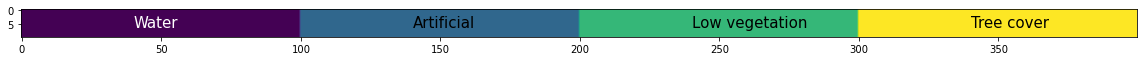

In [37]:
# original image
plt.figure(figsize=(20,10))
plt.imshow(im_comp)

# visualisation of results
Y_im_svm = Y_pred_svm.reshape(coll[1].shape)
plt.figure(figsize=(20,10))
plt.imshow(Y_im_svm)

# legend
fig = plt.figure(figsize=(20,1))
ax = fig.add_subplot(111)
plt.imshow(np.hstack((np.zeros((10,100)), np.ones((10,100)),2*np.ones((10,100)),3*np.ones((10,100)))))
ax.text(40, 6, 'Water', fontsize=15,  color='white')
ax.text(140, 6, 'Artificial', fontsize=15,  color='black')
ax.text(240, 6, 'Low vegetation', fontsize=15,  color='black')
ax.text(340, 6, 'Tree cover', fontsize=15,  color='black')

In [42]:
# saving classification results
io.imsave(resFolder+'\classification_svm.tif',Y_im_svm)

## 6. Loading and displaying localisations of validation points

In [27]:
# loading localisation and LC classes of validation points
#
# validation points are stored in a file which contains lines consisting of triples of integer numbers Y, X and C 
# separated by line space:
# Y is a horizontal (row) pixel coordinate of a validation point
# X is a vertical (column) pixel coordinate of the point
# C is a land cover class index (0 for water, 1 for artificial surfaces, 2 for low vegetation and 3 for tree cover)

p_val = np.loadtxt(valPoints,dtype='int')



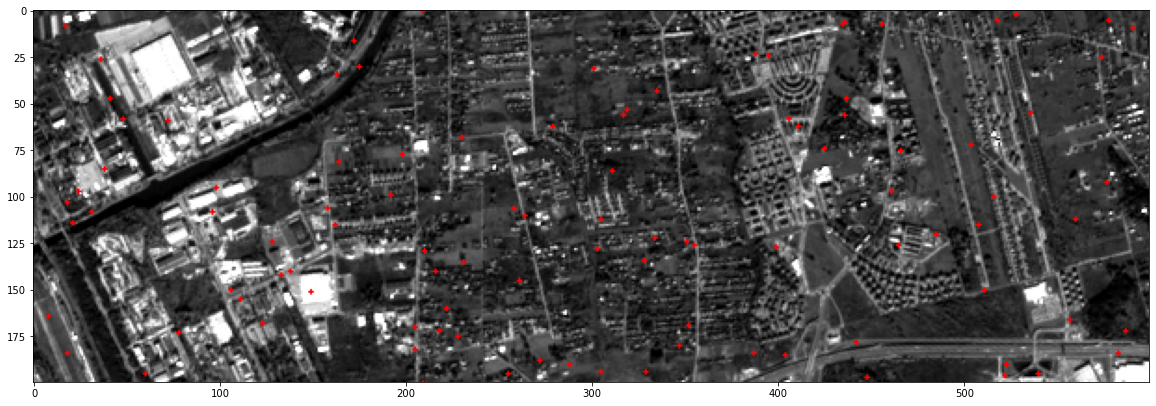

In [28]:
# displaying localisation of validation points on the S2 image

# converting the S2 composition to gray scale
im_comp_p=np.zeros(im_comp.shape)
im_comp_p[:,:,0]=rgb2gray(im_comp)
im_comp_p[:,:,1]=rgb2gray(im_comp)
im_comp_p[:,:,2]=rgb2gray(im_comp)

# marking in red the validation points
im_comp_p[p_val[:,0],p_val[:,1],0] =1
im_comp_p[p_val[:,0],p_val[:,1],1] =0
im_comp_p[p_val[:,0],p_val[:,1],2] =0
im_comp_p[p_val[:,0]+1,p_val[:,1],0] =1
im_comp_p[p_val[:,0]+1,p_val[:,1],1] =0
im_comp_p[p_val[:,0]+1,p_val[:,1],2] =0
im_comp_p[p_val[:,0]-1,p_val[:,1],0] =1
im_comp_p[p_val[:,0]-1,p_val[:,1],1] =0
im_comp_p[p_val[:,0]-1,p_val[:,1],2] =0
im_comp_p[p_val[:,0],p_val[:,1]+1,0] =1
im_comp_p[p_val[:,0],p_val[:,1]+1,1] =0
im_comp_p[p_val[:,0],p_val[:,1]+1,2] =0
im_comp_p[p_val[:,0],p_val[:,1]-1,0] =1
im_comp_p[p_val[:,0],p_val[:,1]-1,1] =0
im_comp_p[p_val[:,0],p_val[:,1]-1,2] =0

plt.figure(figsize=(20,10))
plt.imshow(im_comp_p)

## 7. Assesing classification performance using validation points

Overall accuracy for Decision Tree: 82.0%
Overall accuracy for Random Forest: 85.0%
Overall accuracy for Support Vector Machine: 85.0%


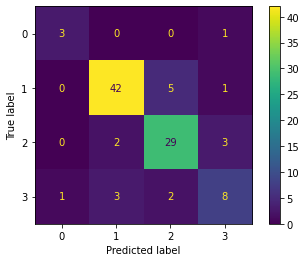

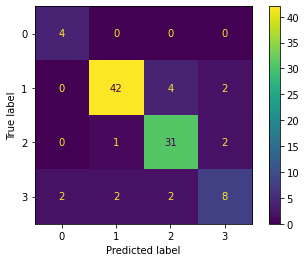

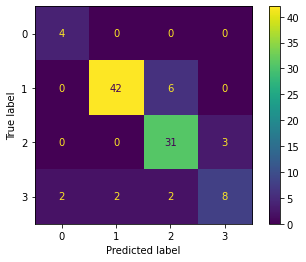

In [39]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score

# reading predictions for validation points from predicted image by different classifiers
pred_dt = Y_im_dt[p_val[:,0],p_val[:,1]] # Decision Tree
pred_rf = Y_im_rf[p_val[:,0],p_val[:,1]] # Random Forest
pred_svm = Y_im_svm[p_val[:,0],p_val[:,1]] # SVM


# overall accuracy
ovAcc_dt = accuracy_score(p_val[:,2],pred_dt)
print("Overall accuracy for Decision Tree: " + str(100*ovAcc_dt) + "%")

ovAcc_rf = accuracy_score(p_val[:,2],pred_rf)
print("Overall accuracy for Random Forest: " + str(100*ovAcc_rf) + "%")

ovAcc_svm = accuracy_score(p_val[:,2],pred_svm)
print("Overall accuracy for Support Vector Machine: " + str(100*ovAcc_svm) + "%")


# confusion matrices
confM_dt = confusion_matrix(p_val[:,2],pred_dt)
confM_rf = confusion_matrix(p_val[:,2],pred_rf)
confM_svm = confusion_matrix(p_val[:,2],pred_svm)

# visualisation of confusion matrices
disp = ConfusionMatrixDisplay(confM_dt)
disp.plot()
disp = ConfusionMatrixDisplay(confM_rf)
disp.plot()
disp = ConfusionMatrixDisplay(confM_svm)
disp.plot()

